In [2]:
import numpy as np
from netCDF4 import Dataset
import sys
sys.path.append('/data/shared_data/scripts/ammss')
from Interpolator import Interpolator

### Load wrfout file

In [3]:
from wrf import getvar, ll_to_xy, ALL_TIMES, interplevel
wrf_path = '/data/shared_data/model/2024052012/wrfout_d03_2024-05-21_13:00:00'
wrfout = Dataset(wrf_path)

/home/lmar/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/lmar/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Extract wspd and z using getvar

In [12]:
wspd, wdir = getvar(wrfout, 'uvmet_wspd_wdir')
z = getvar(wrfout, 'z', msl=False)

In [13]:
wspd

<xarray.DataArray 'uvmet_wspd_wdir' (bottom_top: 50, south_north: 145,
                                     west_east: 320)> Size: 9MB
array([[[2.8118963, 2.8917396, 2.9730172, ..., 5.5219665, 5.2579093,
         4.9894643],
        [2.8352404, 2.9145029, 2.9886518, ..., 5.4389615, 5.140075 ,
         4.849659 ],
        [2.8531733, 2.935212 , 3.006989 , ..., 5.343144 , 5.0114713,
         4.7170367],
        ...,
        [3.627493 , 3.6421728, 3.6828513, ..., 5.422448 , 5.50505  ,
         5.6003895],
        [3.611383 , 3.5978289, 3.6909592, ..., 5.44959  , 5.5150876,
         5.6002426],
        [3.6617029, 3.645229 , 3.670725 , ..., 5.4832606, 5.5391207,
         5.609098 ]],

       [[3.3607564, 3.4571002, 3.5327506, ..., 4.415135 , 4.1660132,
         3.9580238],
        [3.371813 , 3.4644945, 3.5359335, ..., 4.3061   , 4.048073 ,
         3.8505769],
        [3.378871 , 3.4570084, 3.5263937, ..., 4.202184 , 3.947205 ,
         3.7495193],
...
        [3.6564088, 3.670282 , 3.6908743, ..., 4.705001 , 4.719431 ,
         4.7338014],
        [3.6801531, 3.6877427, 3.7068288, ..., 4.647509 , 4.662754 ,
         4.679281 ],
        [3.7078855, 3.7128732, 3.7244332, ..., 4.5798283, 4.6003985,
         4.6218767]],

       [[2.415019 , 2.4370887, 2.4623477, ..., 4.0802984, 4.1365986,
         4.1771727],
        [2.4076135, 2.426772 , 2.4493623, ..., 4.0201087, 4.084873 ,
         4.1374636],
        [2.4042313, 2.4225874, 2.4429913, ..., 3.9467094, 4.017384 ,
         4.0805736],
        ...,
        [3.2497077, 3.23083  , 3.1883042, ..., 6.2350435, 6.2361226,
         6.2383738],
        [3.2525122, 3.2354605, 3.206048 , ..., 6.1551704, 6.157498 ,
         6.1596518],
        [3.2461343, 3.226392 , 3.210912 , ..., 6.0606747, 6.07531  ,
         6.0821857]]], dtype=float32)
Coordinates:
    wspd_wdir  <U4 16B 'wspd'
    XLONG      (south_north, west_east) float32 186kB -3.986 -3.973 ... 0.01031
    XLAT       (south_north, west_east) float32 186kB 54.24 54.24 ... 55.28
    XTIME      float32 4B 1.5e+03
    Time       datetime64[ns] 8B 2024-05-21T13:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  earth rotated wspd,wdir
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-2.0, moad_cen_lat=57.0, truelat...

### Choose desired levels of altitude that we will interpolate our data to. Here we have used numpy to generate an array of integers, but we could also do this manually if we were intested in more specific levels e.g. `desiredlev=[400, 800, 1500]`.

In [14]:
desiredlev = np.arange(25, 5025, 10)
desiredlev

array([  25,   35,   45,   55,   65,   75,   85,   95,  105,  115,  125,
        135,  145,  155,  165,  175,  185,  195,  205,  215,  225,  235,
        245,  255,  265,  275,  285,  295,  305,  315,  325,  335,  345,
        355,  365,  375,  385,  395,  405,  415,  425,  435,  445,  455,
        465,  475,  485,  495,  505,  515,  525,  535,  545,  555,  565,
        575,  585,  595,  605,  615,  625,  635,  645,  655,  665,  675,
        685,  695,  705,  715,  725,  735,  745,  755,  765,  775,  785,
        795,  805,  815,  825,  835,  845,  855,  865,  875,  885,  895,
        905,  915,  925,  935,  945,  955,  965,  975,  985,  995, 1005,
       1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095, 1105, 1115,
       1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195, 1205, 1215, 1225,
       1235, 1245, 1255, 1265, 1275, 1285, 1295, 1305, 1315, 1325, 1335,
       1345, 1355, 1365, 1375, 1385, 1395, 1405, 1415, 1425, 1435, 1445,
       1455, 1465, 1475, 1485, 1495, 1505, 1515, 15

### using the wrf-python `interplevel` function, interpolate both wspd and z to our desired altitude levels - note: you can also interpolate to pressure levels! Just load 'pressure' using wrf-python and substitude it for z below, be aware that you will then need to change you desired levels accordingly!

In [15]:
wspd_on_alt = interplevel(wspd, z, desiredlev=desiredlev)


In [16]:
z_on_alt = interplevel(z, z, desiredlev=desiredlev)

In [17]:
import matplotlib.pyplot as plt

### Use our nearest grid points to index the wspd and z arrays, not that we include all of the first dimension: up_down, using `:`

In [18]:
grid_ref_flt = ll_to_xy(wrfout, 54.596488, -3.140254, as_int=False)
grid_ref_int = ll_to_xy(wrfout, 54.596488, -3.140254, as_int=True)

In [19]:
grid_ref_int

<xarray.DataArray 'xy' (x_y: 2)> Size: 16B
array([69, 48])
Coordinates:
    latlon_coord  object 8B CoordPair(lat=54.596488, lon=-3.140254)
  * x_y           (x_y) <U1 8B 'x' 'y'

### Get the wrf grid coords as floats (decimal numbers) i.e. exact location of the chosen lat long in the wrf grid and as integers i.e. nearest gridpoint to the chosen lat long in the wrf grid

### Create an Interpolator to allow us to interpolate data to the exact location of 'float' grid coords

In [20]:
interps_flt = Interpolator(grid_ref_flt[1], grid_ref_flt[0])

In [46]:
wspd_alt_ngp = wspd_on_alt[:,grid_ref_int[1],grid_ref_int[0]]
z_alt_ngp = z_on_alt[:,grid_ref_int[1], grid_ref_int[0]]

### Use the `.interp` method of our Interpolator object to get the values of wspd and z at the 'exact' location of the lat long. Note that this method will interpolate on the **last** two dimensions of the array you pass it, i.e. it will skip the first dimension, similarily to how we used all values in the first dimension in the above cell.

In [37]:
wspd_alt_flt = interps_flt.interp(wspd_on_alt.to_numpy())
z_alt_flt = interps_flt.interp(z_on_alt.to_numpy())

### Reading Sonde data

In [38]:
import pandas as pd

In [39]:
file = '/data/shared_data/public/2024-05-21_1219.raw_flight_history.csv'

def get_lat_lon_from_height(file, altitude):
    flight = pd.read_csv(file)
    flight.columns = [header.strip() for header in flight.columns]
    flight.columns
    for column in ['Altitude (m AGL)', 'Latitude', 'Longitude']:
        flight[column] = flight[column].apply(pd.to_numeric, errors='coerce')
    flight.dropna(subset=['Altitude (m AGL)', 'Latitude', 'Longitude'], inplace=True)
    row = flight.iloc[(flight['Altitude (m AGL)']-altitude).abs().argsort()[0]]
    return row['Latitude'], row['Longitude']

In [40]:
get_lat_lon_from_height(file, 0)

(54.596443, -3.140547)

In [41]:
sounding = pd.read_csv('/data/shared_data/public/2024-05-21_1219.sounding.csv', header=1)
sounding.columns = [header.strip() for header in sounding.columns]
p_0 = 1000 #mb
r_cp = 0.286

In [42]:
sounding

,Height (m AGL),Pressure (mb),Temperature (C),Relative humidity (%),Wind speed (m/s),Wind direction (true deg)
0,20,998.81,17.56,55.6,5.44,69.2
1,40,996.49,17.25,55.6,5.65,69.7
2,60,994.16,16.96,55.4,5.77,70.6
3,80,991.85,16.87,54.6,5.99,71.5
4,100,989.53,16.81,53.7,6.09,73.6
...,...,...,...,...,...,...
249,5000,540.71,-11.62,44.2,6.70,134.3
250,5020,539.31,-11.71,42.7,6.77,133.7
251,5040,537.91,-11.92,41.0,6.85,134.0
252,5060,536.51,-12.01,40.2,6.78,136.1


# Let's plot!

In [43]:
z_ngp = z[:,grid_ref_int[1], grid_ref_int[0]]

Text(0.5, 1.0, 'WRF forecast at 2024-05-21 13:00:00')

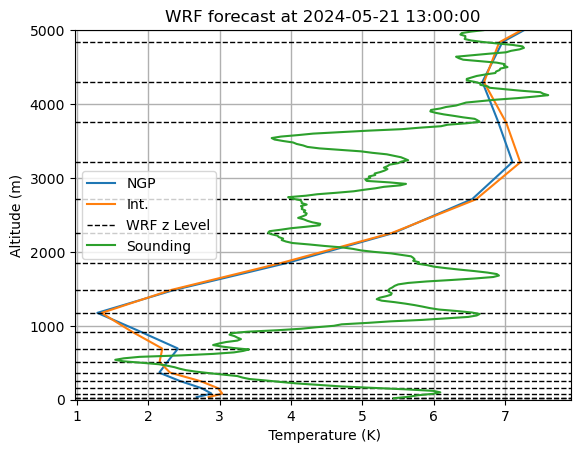

In [45]:
plt.plot(wspd_alt_ngp, z_alt_ngp, label='NGP')
plt.plot(wspd_alt_flt, z_alt_flt, label='Int.')

#add wrf heightlevel
for lev in z_ngp:
    plt.axhline(y= lev, linestyle='--', linewidth=1, color='k')
    
plt.axhline(y= z_ngp[0], linestyle='--', linewidth=1, color='k', label='WRF z Level')
plt.plot(sounding['Wind speed (m/s)'], sounding['Height (m AGL)'], label='Sounding')
plt.grid(linewidth=1)
plt.ylim((0, 5000))
plt.xlabel(' Temperature (K)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.title(f"WRF forecast at {wrf_path.split('_')[-2]} {wrf_path.split('_')[-1]}")

NameError: name 'z_ngp' is not defined

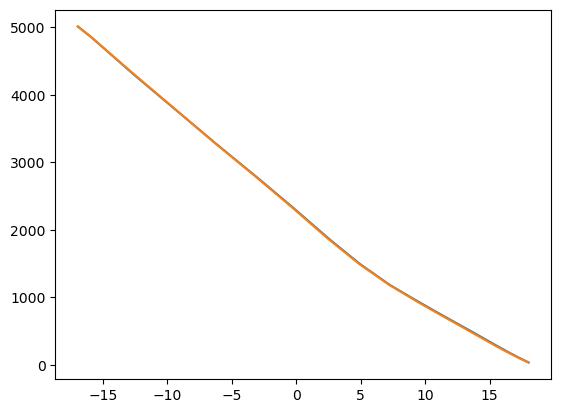

In [34]:
plt.plot(tk_alt_ngp - 273.15, z_alt_ngp, label='NGP')
plt.plot(tk_alt_int - 273.15, z_alt_int, label='Int.')
for lev in z_ngp:
    plt.axhline(y= lev, linestyle='--', linewidth=1, color='k')
plt.axhline(y= z_ngp[0], linestyle='--', linewidth=1, color='k', label='WRF z Level')
plt.plot(sounding['Temperature (C)'], sounding['Height (m AGL)'], label='Sounding')
plt.grid(linewidth=1)
plt.xlabel(' Temperature (C)')
plt.ylabel('Altitude (m)')
plt.ylim((0, 5000))
plt.legend()
plt.title(f"WRF forecast at {wrf_path.split('_')[-2]} {wrf_path.split('_')[-1]}")

# Note on the madness of WRF vertical levels

### Let's look at what the raw WRF levels look like prior to interpolating to vertical levels using `interplevel`. We will do this by looking at `z` at our nearest gridpoint:

In [ ]:
z_ngp = z[:,grid_ref_int[1], grid_ref_int[0]]
z_ngp

In [ ]:
plt.plot(z_ngp, marker='.', linestyle='')
plt.grid()
plt.xlabel('WRF Level')
plt.ylabel('Height above ground level (m)')

### As out lowest level is around 25m, we must make sure our desired levels are above this or we will get some `NaN`s!!!